------------------------------------------------------------
# **Power Demand Forecasting for Karnataka using LSTM**
-------------------------------------------------------------

## **Exploratory Data Analysis**

Objectives:

* Understand the overall demand and energy trends over time.
* Analyze the relationship between temperature and electricity demand.
* Detect seasonal or yearly patterns in energy consumption.
* Check for demand anomalies or shortages.
* Prepare the data for LSTM modeling (stationarity, missing data, etc.)

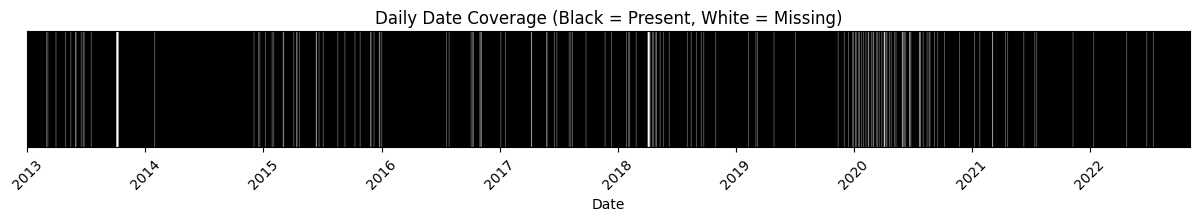

Total expected days: 3594
Actual days in dataset: 3435
Missing days: 159
Missing Dates (first 10):
DatetimeIndex(['2013-05-30', '2013-06-03', '2013-06-28', '2013-07-27',
               '2013-08-13', '2013-08-28', '2013-08-29', '2013-09-14',
               '2013-09-20', '2013-09-23'],
              dtype='datetime64[ns]', freq=None)

Rows with missing values before filling: 159
Missing values per column before filling:
date                                    0
Region                                159
States                                159
Max.Demand Met during the day(MW)     159
Shortage during maximum Demand(MW)    159
Energy Met (MU)                       159
temp_avg_karnataka                    159
DayName                                 0
MonthName                               0
Year                                    0
Month                                   0
Quarter                                 0
Season                                  0
dtype: int64

Missing values aft

/tmp/ipython-input-132491819.py:75: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_full[col] = df_full[col].fillna(method='ffill').fillna(method='bfill')


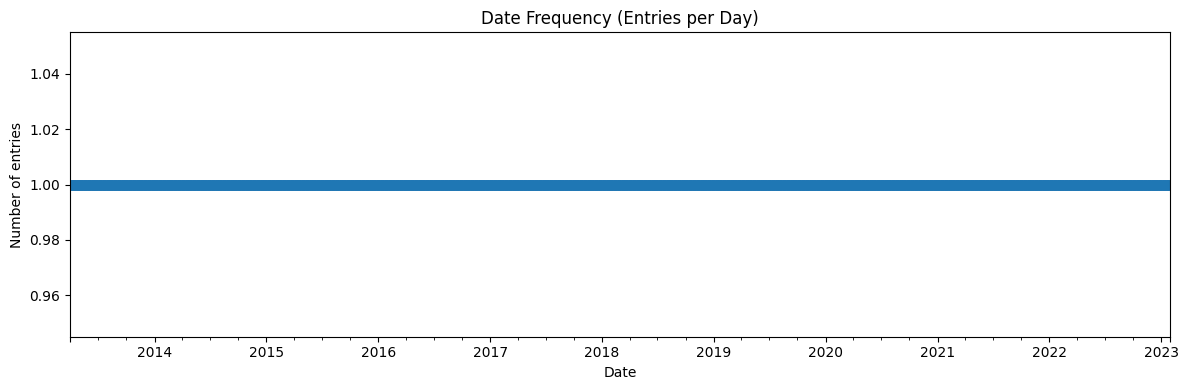

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 0: Load the dataset
df_merged['date'] = pd.to_datetime(df_merged['date'])

# Step 1: Aggregate duplicate dates by taking the mean of numerical values
df_daily = df_merged.groupby('date', as_index=False).agg({
    'Region': 'first',
    'States': 'first',
    'Max.Demand Met during the day(MW)': 'mean',
    'Shortage during maximum Demand(MW)': 'mean',
    'Energy Met (MU)': 'mean',
    'temp_avg_karnataka': 'mean'
})

# Step 2: Create a full daily date range as DataFrame
full_dates = pd.date_range(start=df_daily['date'].min(), end=df_daily['date'].max())
full_dates_df = pd.DataFrame({'date': full_dates})

# Optional: Plot missing dates (black = present, white = missing)
date_coverage = pd.Series(1, index=df_daily['date'])
date_coverage = date_coverage.reindex(full_dates, fill_value=0)

plt.figure(figsize=(15, 1.5))
plt.imshow([date_coverage.values], cmap='Greys', aspect='auto')
plt.title("Daily Date Coverage (Black = Present, White = Missing)")
plt.yticks([])
plt.xticks(
    ticks=range(0, len(full_dates), 365),
    labels=[full_dates[i].strftime('%Y') for i in range(0, len(full_dates), 365)],
    rotation=45
)
plt.xlabel("Date")
plt.show()

# Identify missing dates
missing_dates = full_dates.difference(df_daily['date'])
print(f"Total expected days: {len(full_dates)}")
print(f"Actual days in dataset: {df_daily['date'].nunique()}")
print(f"Missing days: {len(missing_dates)}")
print("Missing Dates (first 10):")
print(missing_dates[:10])

# Step 3: Merge with full date range
df_full = pd.merge(full_dates_df, df_daily, on='date', how='left')

# Step 4: Add time-based features
df_full['DayName'] = df_full['date'].dt.day_name()
df_full['MonthName'] = df_full['date'].dt.month_name()
df_full['Year'] = df_full['date'].dt.year
df_full['Month'] = df_full['date'].dt.month
df_full['Quarter'] = df_full['date'].dt.quarter

# Add Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

df_full['Season'] = df_full['Month'].apply(get_season)

# Step 5: Handle Missing Values
print(f"\nRows with missing values before filling: {df_full.isnull().any(axis=1).sum()}")
print("Missing values per column before filling:")
print(df_full.isnull().sum())

# Fill categorical columns
for col in ['Region', 'States']:
    df_full[col] = df_full[col].fillna(method='ffill').fillna(method='bfill')

# Fill numerical columns
num_cols = ['Max.Demand Met during the day(MW)',
            'Shortage during maximum Demand(MW)',
            'Energy Met (MU)',
            'temp_avg_karnataka']
df_full[num_cols] = df_full[num_cols].interpolate(method='linear')

# Step 6: Export cleaned dataset
df_full.to_csv("Filled_Daily_Power_Karnataka.csv", index=False)

# Step 7: Final check and plot
print("\nMissing values after filling:")
print(df_full.isnull().sum())

print("\nTime Coverage and Frequency:")
print("Start Date:", df_full['date'].min())
print("End Date:", df_full['date'].max())
print(f"Total unique days: {df_full['date'].nunique()}")

df_full['date'].value_counts().sort_index().plot(
    figsize=(12, 4),
    title='Date Frequency (Entries per Day)',
    marker='o'
)
plt.ylabel("Number of entries")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


## **Plot 2: Daily Power Demand and Shortage over time**

A line plot was created showing daily Max Demand Met and Shortage during Maximum Demand from 2013 to 2023.



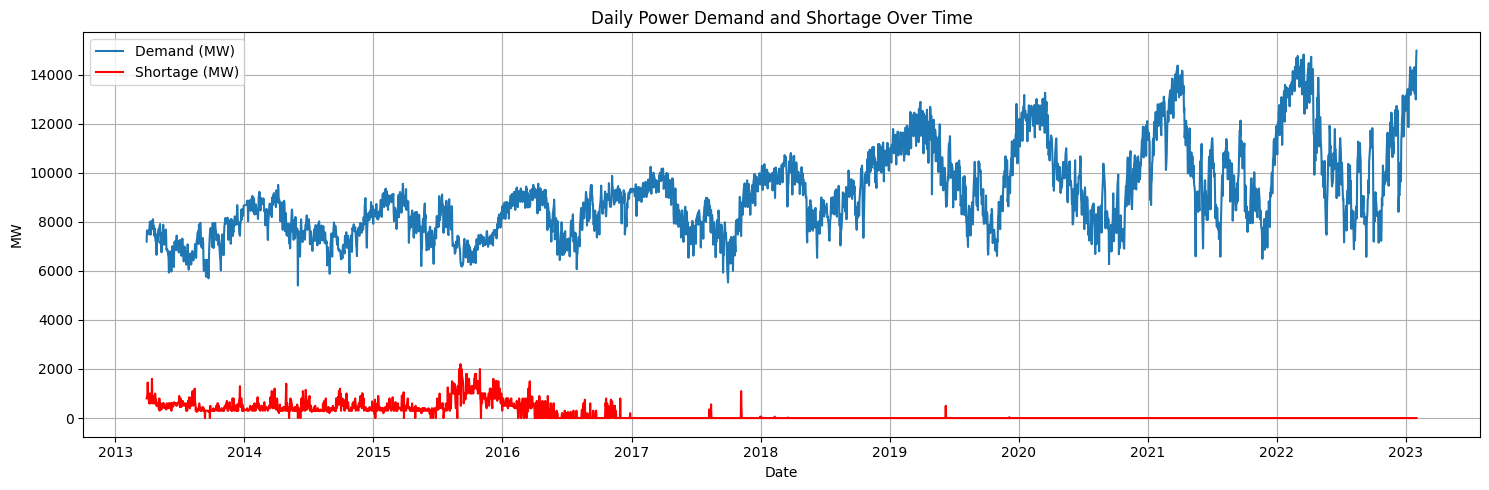

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df_full['date'], df_full['Max.Demand Met during the day(MW)'], label='Demand (MW)')
plt.plot(df_full['date'], df_full['Shortage during maximum Demand(MW)'], label='Shortage (MW)', color='red')
plt.title("Daily Power Demand and Shortage Over Time")
plt.xlabel("Date")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Inference

From the plot the blue line plot is a time series plot for Power Demand in Karnataka. It clearly exhibits an upward trend.

The red line plot, is another time series plot for Power Shortage in Karnataka. It shows significant shortages up until 2017 after which there isn't much spike, this would likely be a suggestion of the improvement in terms of power generation capability.

## **Plot 3: Monthly Patterns**

A bar chart was plotted to visualize the average of daily max demand met and average daily shortage for each month.

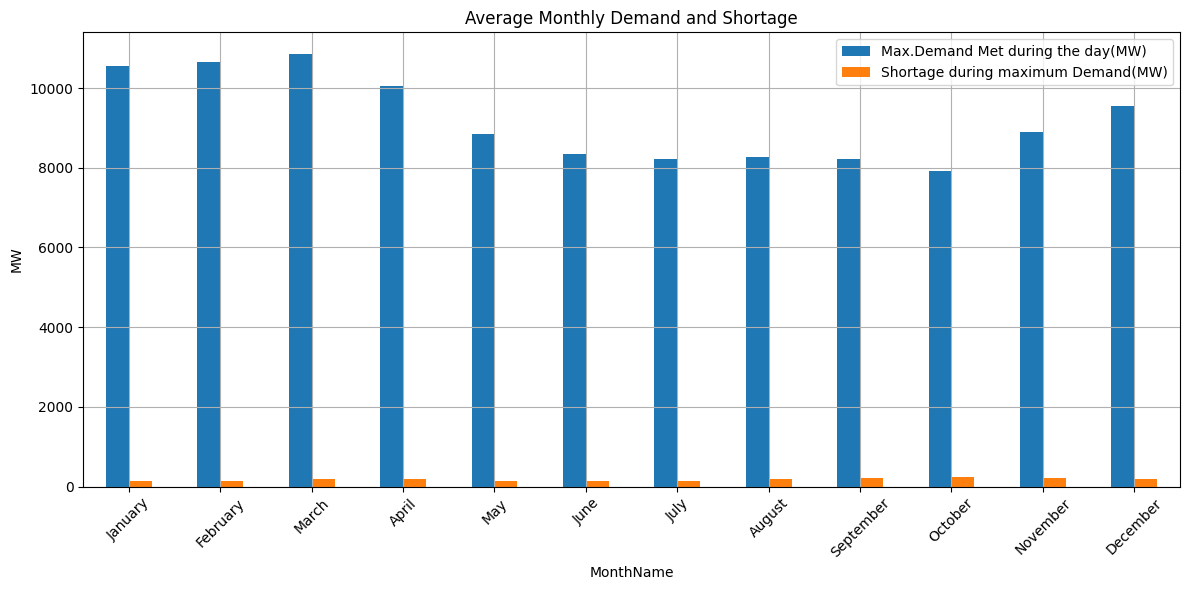

In [ ]:
# Monthly Patterns in Power Demand

monthly_avg = df_full.groupby('MonthName')[['Max.Demand Met during the day(MW)', 'Shortage during maximum Demand(MW)']].mean()
monthly_avg = monthly_avg.loc[['January','February','March','April','May','June','July','August','September','October','November','December']]

monthly_avg.plot(kind='bar', figsize=(12, 6))
plt.title("Average Monthly Demand and Shortage")
plt.ylabel("MW")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## Inference

This plot verifies that the shortages have been consistently low across all months.

## **Plot 4: Seasonal Average Demand and Shortage**

A bar chart was plotted to visualize the average demand and shortage were grouped by season (Winter, Summer, Monsoon, Post-Monsoon).

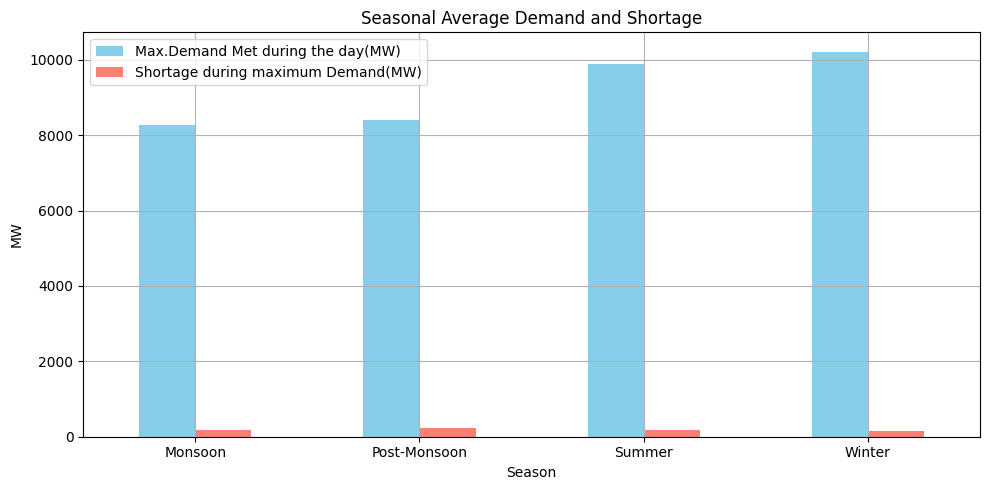

In [ ]:
# Seasonal Impact on Demand and Storage

seasonal_avg = df_full.groupby('Season')[['Max.Demand Met during the day(MW)', 'Shortage during maximum Demand(MW)']].mean()
seasonal_avg.plot(kind='bar', figsize=(10, 5), color=['skyblue', 'salmon'])
plt.title("Seasonal Average Demand and Shortage")
plt.ylabel("MW")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


## **Plot 5: Distribution of Energy Met (MU)**

A histogram was plotted showing the frequency distribution of Energy Met in Mega Units (MU).

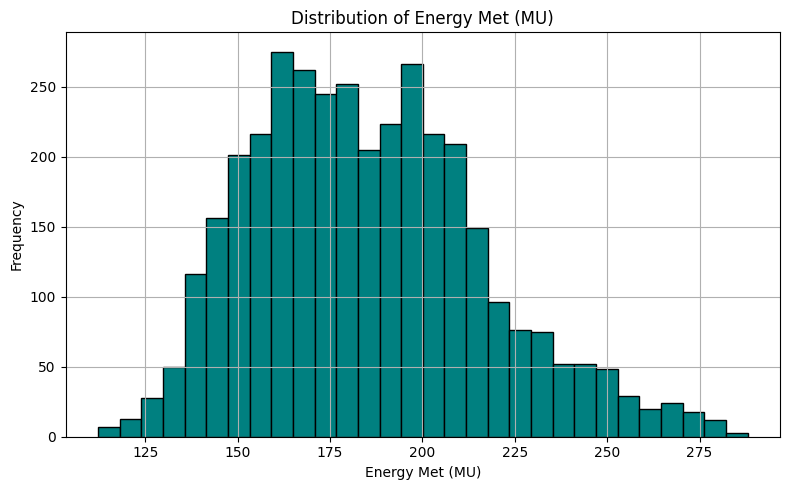

In [ ]:
# Distribution of Daily Energy Met

plt.figure(figsize=(8, 5))
plt.hist(df_full['Energy Met (MU)'], bins=30, color='teal', edgecolor='black')
plt.title("Distribution of Energy Met (MU)")
plt.xlabel("Energy Met (MU)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


## **Plot 6: Temperature vs. Power Demand**

To analyze the effect of climate, a scatter plot of temperature vs. power demand was generated.

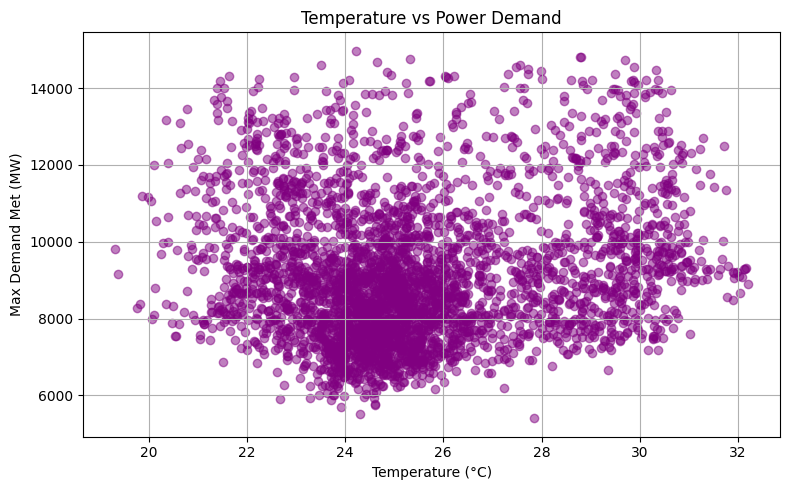

In [ ]:
# Relationship between Temperature and Power Demand

plt.figure(figsize=(8, 5))
plt.scatter(df_full['temp_avg_karnataka'], df_full['Max.Demand Met during the day(MW)'], alpha=0.5, color='purple')
plt.title("Temperature vs Power Demand")
plt.xlabel("Temperature (°C)")
plt.ylabel("Max Demand Met (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()


## **Plot 7: Correlation Analysis**

A correlation heatmap was also generated for major variables like temperature, max demand, shortage, and energy met.

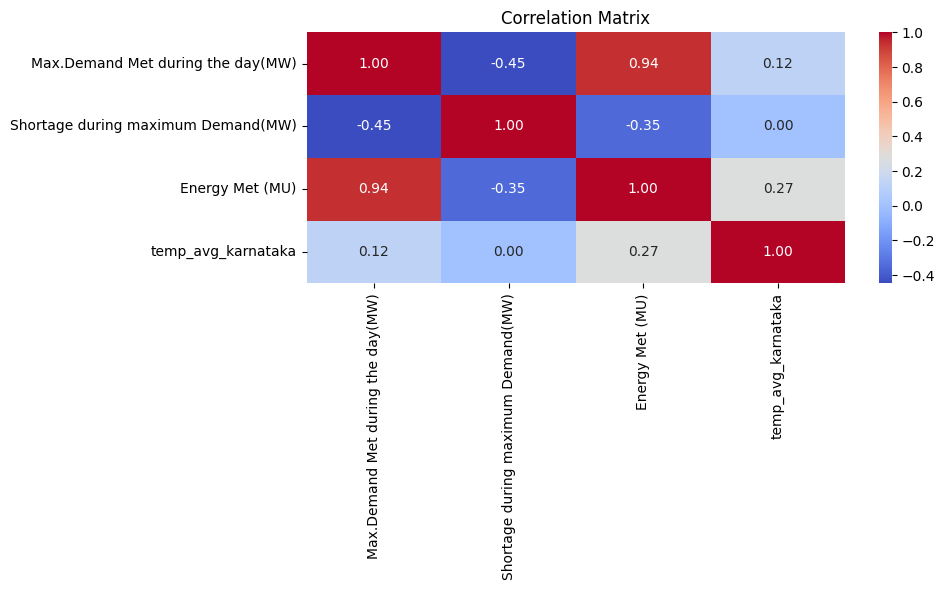

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
corr = df_full[['Max.Demand Met during the day(MW)',
                'Shortage during maximum Demand(MW)',
                'Energy Met (MU)',
                'temp_avg_karnataka']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


## Inference

- Temperature has a positive correlation with both Energy Met and Max Demand, supporting earlier scatter plot findings.
- Energy Met and Max Demand are strongly correlated, as expected.


In [ ]:
# Top 10 days with highest shortage

top_shortages = df_full[['date', 'Shortage during maximum Demand(MW)']].sort_values(by='Shortage during maximum Demand(MW)', ascending=False).head(10)
print("Top 10 Days with Highest Shortage:\n")
print(top_shortages)


Top 10 Days with Highest Shortage:

          date  Shortage during maximum Demand(MW)
888 2015-09-05                              2200.0
891 2015-09-08                              2000.0
884 2015-09-01                              2000.0
943 2015-10-30                              2000.0
929 2015-10-16                              1800.0
904 2015-09-21                              1800.0
932 2015-10-19                              1800.0
930 2015-10-17                              1800.0
890 2015-09-07                              1800.0
906 2015-09-23                              1800.0


## **Plot 8: Seasonal Energy Demand**



/tmp/ipython-input-49-1006484908.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_full, x='Season', y='Energy Met (MU)', palette='Set2')


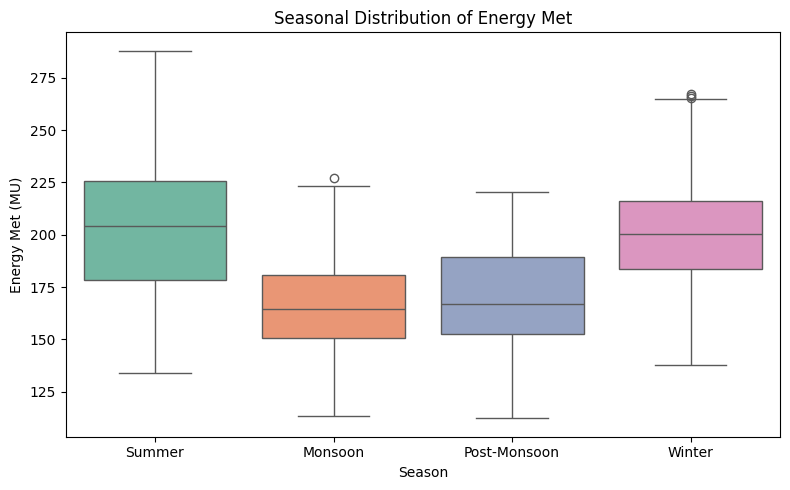

In [ ]:
# Seasonal Energy Demand

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_full, x='Season', y='Energy Met (MU)', palette='Set2')
plt.title("Seasonal Distribution of Energy Met")
plt.ylabel("Energy Met (MU)")
plt.xlabel("Season")
plt.tight_layout()
plt.show()


## Inference

The boxplot illustrates the seasonal distribution of energy met (in MU) across Summer, Monsoon, Post-Monsoon, and Winter seasons.

Summer and Winter seasons show the highest median energy met, both around 200 MU, indicating elevated energy demand during these periods—likely due to increased usage of cooling (summer) and heating (winter) appliances.

Summer has the widest spread (interquartile range) and the highest maximum value (nearly 290 MU), suggesting greater variability in energy consumption—possibly due to heatwaves or fluctuating usage patterns.

Monsoon season records the lowest median energy met (~165 MU) and also has a narrower spread, indicating relatively lower and more stable energy demand, likely due to milder temperatures and reduced HVAC usage.

Post-Monsoon shows a similar pattern to Monsoon but with a slightly higher and more spread-out distribution, reflecting transitional climatic conditions.

Outliers are visible in Monsoon and Winter, suggesting occasional days with unusually high energy demand, which may correspond to specific events or anomalies.

